In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
#loeme andmed sisse
data_orig=pd.read_csv("soidukid.csv",on_bad_lines='skip', sep=";")

C:\Users\Liis Reimand\AppData\Local\Temp\ipykernel_20048\1789013292.py:2: DtypeWarning: Columns (8,9,21) have mixed types. Specify dtype option on import or set low_memory=False.
  data_orig=pd.read_csv("soidukid.csv",on_bad_lines='skip', sep=";")


In [3]:
#kopeerime originaalse andmestiku
data=data_orig.copy()

In [4]:
#kustutame ebavajalikud andmed
data=data[data.YLDINE_STAATUS != "PEATATUD"]
data=data.reset_index()
data=data.drop(["Andmed seisuga","index","VARV","ISTEKOHTI", "Kere nimetus", "ARV","Kategooria","Keretüüp","TELGI_KOKKU","TAISMASS", "TYHIMASS","YLDINE_STAATUS","EESTIS_ESMAREG_KP", "MOOTORI_TYYP", "Kütuse tüüp", "HYBRIIDI_TYYP"], axis=1)

In [5]:
#asendame Nan-informatsioonilahtrid käigukastitüübis
#Nan -> manuaal
data["KAIGUKASTI_TYYP"]=data["KAIGUKASTI_TYYP"].fillna("MANUAAL")

In [6]:
#asendame puuduvad NEDC väärtused võimalusel WLTP omadega, vastasel juhul
#eelistame NEDC

for i in range(len(data["CO2_NEDC"])):
    vana=data["CO2_NEDC"].iloc[i]
    uus=data["CO2_WLTP"].iloc[i]
    if str(vana)=="nan" and str(uus)!="nan":
        data.loc[i,'CO2_NEDC']=int(uus)
data=data.drop(["CO2_WLTP"], axis=1)        

In [7]:
#data.to_csv('soidukid_cleaned.csv',encoding='utf-8-sig',sep=';')

In [8]:
#VAZ-de CO2_NEDC NaN väärtused asendame 210-ga, kuna antud autod omavad sama mootorit
for i in range(len(data["CO2_NEDC"])):
    mark=data["Mark"].iloc[i]
    if str(mark)=="VAZ":
        data.loc[i,'CO2_NEDC']=210

In [9]:
#Vaatame autosid, millel on CO2 NaN-valued
#for i in range(len(data["CO2_NEDC"])):
 #  mark=data["Mark"].iloc[i]
  #  maht=data["MOOTORI_MAHT"].iloc[i]
   # tüüp=data["Kütusekombinatsioon"].iloc[i]
    #if str(NEDC)=="nan" and str(mark)=="BMW":
     #   print(str(data["Mark"].iloc[i])+ " " + str(data["Mudel"].iloc[i]) + " " + str(maht) + " " + str(tüüp))

In [10]:
#Peamised mootorid ning nende CO2_NEDC, et vähendada NaN valuesid CO2 tulbas
motoras_VW={1968.0:146.0, 1896.0:162.0, 2461.0:171.0, 2771.0:255.0, 2967.0:180.0 ,1781.0:190.0, 2792.0:278.0}
motoras_BMW={1596.0:171.6, 1991.0:165.3, 2979.0:169.0, 2993.0:170.0, 2926.0:178.0, 1995.0:153.0, 1796.0:208.0, 1950.0:158.0}

In [11]:
#Asendame NaN-valued võimalusel Volkswageni ja Audi peamiste mootorite CO2 reostustasemed
for i in range(len(data["CO2_NEDC"])):
    mootor=data["MOOTORI_MAHT"].iloc[i]
    NEDC=data["CO2_NEDC"].iloc[i]
    mark=data["Mark"].iloc[i]
    if str(NEDC)=="nan" and float(mootor) in motoras_VW.keys() and (str(mark)=="VOLKSWAGEN" or str(mark)=="AUDI"):
        data.loc[i,'CO2_NEDC']=int(motoras_VW.get(float(mootor)))

In [12]:
#Asendame NaN-valued võimalusel BMW peamiste mootorite CO2 reostustasemed
for i in range(len(data["CO2_NEDC"])):
    mootor=data["MOOTORI_MAHT"].iloc[i]
    NEDC=data["CO2_NEDC"].iloc[i]
    mark=data["Mark"].iloc[i]
    if str(NEDC)=="nan" and float(mootor) in motoras_BMW.keys() and str(mark)=="BMW":
        data.loc[i,'CO2_NEDC']=int(motoras_BMW.get(float(mootor)))

In [13]:
#Asendame NaN-valued elektri-autodel nulliga
for i in range(len(data["CO2_NEDC"])):
    kütus=data["Kütusekombinatsioon"].iloc[i]
    NEDC=data["CO2_NEDC"].iloc[i]
    if str(NEDC)=="nan" and str(kütus)=="ELEKTER":
        data.loc[i,'CO2_NEDC']=0

In [14]:
brändid={}
for i in range(len(data["CO2_NEDC"])):
    NEDC=data["CO2_NEDC"].iloc[i]
    if str(NEDC)=="nan":
        if str(data["Mark"].iloc[i]) in brändid.keys():
            brändid[str(data["Mark"].iloc[i])]= int(brändid.get(str(data["Mark"].iloc[i])))+1
        else:
            brändid[str(data["Mark"].iloc[i])]= 1             
brändid=dict(sorted(brändid.items(), key=lambda item: item[1]))
#print(brändid)

In [15]:
#Asendame vigased maakonna nimed
tundmatud=['L��NE-VIRU MAAKOND', 'P�RNU MAAKOND', 'J�RVA MAAKOND', 'P�LVA MAAKOND', 'V�RU MAAKOND']
asendused=["LÄÄNE-VIRU MAAKOND", "PÄRNU MAAKOND", "JÄRVA MAAKOND", "PÕLVA MAAKOND", "VÕRU MAAKOND"]

for i in range(len(tundmatud)):
    data["VK/OM MAAKOND"]=data["VK/OM MAAKOND"].replace([tundmatud[i]],asendused[i])
    
MAAKONNAD=[]
for i in range(len(data["VK/OM MAAKOND"])):
    maakond=data["VK/OM MAAKOND"].iloc[i]
    if str(maakond) not in MAAKONNAD:
        MAAKONNAD.append(str(maakond))

In [16]:
autod_maakonnas={'HARJU MAAKOND':0, 'PÄRNU MAAKOND':0, 'TARTU MAAKOND':0, 'VALGA MAAKOND':0, 'VÕRU MAAKOND':0, 'HIIU MAAKOND':0, 'PÕLVA MAAKOND':0, 'SAARE MAAKOND':0, 'LÄÄNE-VIRU MAAKOND':0, 'IDA-VIRU MAAKOND':0, 'JÕGEVA MAAKOND':0, 'LÄÄNE MAAKOND':0, 'RAPLA MAAKOND':0, 'VILJANDI MAAKOND':0, 'JÄRVA MAAKOND':0, 'MÄÄRAMATA':0}
passatid_maakonnas={'HARJU MAAKOND':0, 'PÄRNU MAAKOND':0, 'TARTU MAAKOND':0, 'VALGA MAAKOND':0, 'VÕRU MAAKOND':0, 'HIIU MAAKOND':0, 'PÕLVA MAAKOND':0, 'SAARE MAAKOND':0, 'LÄÄNE-VIRU MAAKOND':0, 'IDA-VIRU MAAKOND':0, 'JÕGEVA MAAKOND':0, 'LÄÄNE MAAKOND':0, 'RAPLA MAAKOND':0, 'VILJANDI MAAKOND':0, 'JÄRVA MAAKOND':0, 'MÄÄRAMATA':0}
passatid_kokku=0

for i in range(len(data["VK/OM MAAKOND"])):
    mudel=data["Mudel"].iloc[i]
    maakond=data["VK/OM MAAKOND"].iloc[i]
    autod_maakonnas[str(maakond)]= int(autod_maakonnas.get(str(maakond)))+1
    if "PASSAT" in str(mudel):
        passatid_kokku+=1
        passatid_maakonnas[str(maakond)]= int(passatid_maakonnas.get(str(maakond)))+1

print("Passateid Eestis " + str(passatid_kokku))
print(autod_maakonnas)
print(passatid_maakonnas)

Passateid Eestis 29261
{'HARJU MAAKOND': 281403, 'PÄRNU MAAKOND': 42387, 'TARTU MAAKOND': 74682, 'VALGA MAAKOND': 14754, 'VÕRU MAAKOND': 20159, 'HIIU MAAKOND': 6339, 'PÕLVA MAAKOND': 15091, 'SAARE MAAKOND': 20174, 'LÄÄNE-VIRU MAAKOND': 29375, 'IDA-VIRU MAAKOND': 48605, 'JÕGEVA MAAKOND': 14729, 'LÄÄNE MAAKOND': 10963, 'RAPLA MAAKOND': 18914, 'VILJANDI MAAKOND': 24343, 'JÄRVA MAAKOND': 15828, 'MÄÄRAMATA': 11487}
{'HARJU MAAKOND': 8835, 'PÄRNU MAAKOND': 2027, 'TARTU MAAKOND': 4346, 'VALGA MAAKOND': 1055, 'VÕRU MAAKOND': 1833, 'HIIU MAAKOND': 276, 'PÕLVA MAAKOND': 1419, 'SAARE MAAKOND': 816, 'LÄÄNE-VIRU MAAKOND': 1317, 'IDA-VIRU MAAKOND': 2101, 'JÕGEVA MAAKOND': 995, 'LÄÄNE MAAKOND': 479, 'RAPLA MAAKOND': 876, 'VILJANDI MAAKOND': 1462, 'JÄRVA MAAKOND': 830, 'MÄÄRAMATA': 594}


In [17]:
for i in range(len(autod_maakonnas)):
    print("Passateid " + str(MAAKONNAD[i]) +" "+ str(round((passatid_maakonnas.get(MAAKONNAD[i])/autod_maakonnas.get(MAAKONNAD[i]))*100,2))+ " %")

Passateid HARJU MAAKOND 3.14 %
Passateid PÄRNU MAAKOND 4.78 %
Passateid TARTU MAAKOND 5.82 %
Passateid VALGA MAAKOND 7.15 %
Passateid VÕRU MAAKOND 9.09 %
Passateid HIIU MAAKOND 4.35 %
Passateid PÕLVA MAAKOND 9.4 %
Passateid SAARE MAAKOND 4.04 %
Passateid LÄÄNE-VIRU MAAKOND 4.48 %
Passateid IDA-VIRU MAAKOND 4.32 %
Passateid JÕGEVA MAAKOND 6.76 %
Passateid LÄÄNE MAAKOND 4.37 %
Passateid RAPLA MAAKOND 4.63 %
Passateid VILJANDI MAAKOND 6.01 %
Passateid JÄRVA MAAKOND 5.24 %
Passateid MÄÄRAMATA 5.17 %


In [18]:
CO2_maakonnas={'HARJU MAAKOND':0, 'PÄRNU MAAKOND':0, 'TARTU MAAKOND':0, 'VALGA MAAKOND':0, 'VÕRU MAAKOND':0, 'HIIU MAAKOND':0, 'PÕLVA MAAKOND':0, 'SAARE MAAKOND':0, 'LÄÄNE-VIRU MAAKOND':0, 'IDA-VIRU MAAKOND':0, 'JÕGEVA MAAKOND':0, 'LÄÄNE MAAKOND':0, 'RAPLA MAAKOND':0, 'VILJANDI MAAKOND':0, 'JÄRVA MAAKOND':0, 'MÄÄRAMATA':0}

for i in range(len(data["CO2_NEDC"])):
    maakond=data["VK/OM MAAKOND"].iloc[i]
    co=data["CO2_NEDC"].iloc[i]
    if str(co)!="nan":
        CO2_maakonnas[str(maakond)]= float(CO2_maakonnas.get(str(maakond))) + float(data["CO2_NEDC"].iloc[i])

In [19]:
CO2_maakonniti=[]
for i in range(len(autod_maakonnas)):
    print("CO2 reostus: " + str(MAAKONNAD[i]) +" "+ str(round((CO2_maakonnas.get(MAAKONNAD[i])/autod_maakonnas.get(MAAKONNAD[i])),2))+ " g/km")
    CO2_maakonniti.append(round((CO2_maakonnas.get(MAAKONNAD[i])/autod_maakonnas.get(MAAKONNAD[i])),2))

CO2 reostus: HARJU MAAKOND 135.47 g/km
CO2 reostus: PÄRNU MAAKOND 130.43 g/km
CO2 reostus: TARTU MAAKOND 132.39 g/km
CO2 reostus: VALGA MAAKOND 128.27 g/km
CO2 reostus: VÕRU MAAKOND 127.07 g/km
CO2 reostus: HIIU MAAKOND 126.2 g/km
CO2 reostus: PÕLVA MAAKOND 126.13 g/km
CO2 reostus: SAARE MAAKOND 124.21 g/km
CO2 reostus: LÄÄNE-VIRU MAAKOND 129.11 g/km
CO2 reostus: IDA-VIRU MAAKOND 137.09 g/km
CO2 reostus: JÕGEVA MAAKOND 129.22 g/km
CO2 reostus: LÄÄNE MAAKOND 127.54 g/km
CO2 reostus: RAPLA MAAKOND 129.7 g/km
CO2 reostus: VILJANDI MAAKOND 127.56 g/km
CO2 reostus: JÄRVA MAAKOND 130.09 g/km
CO2 reostus: MÄÄRAMATA 134.39 g/km


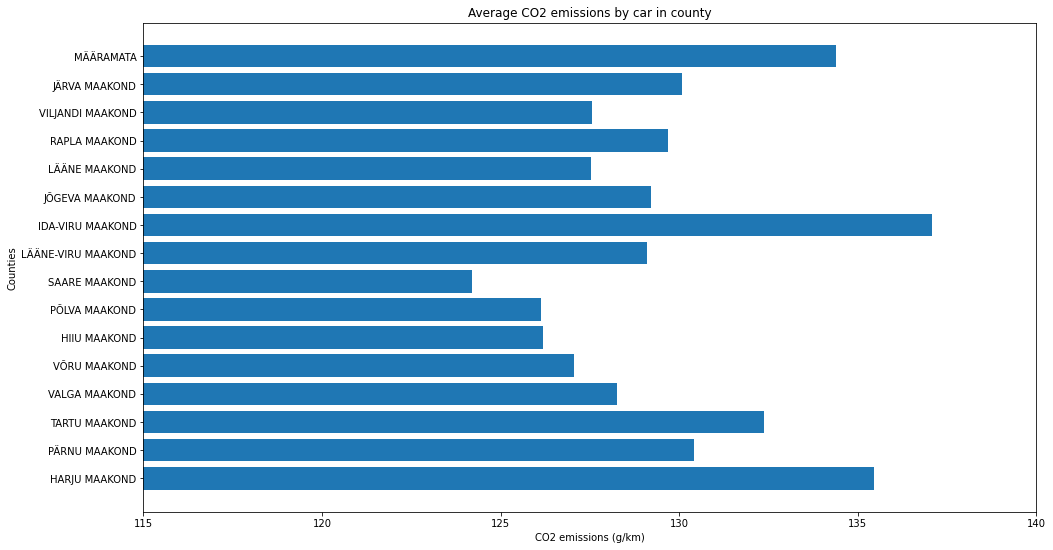

In [20]:
fig, ax = plt.subplots(figsize =(16, 9))

ax.barh(MAAKONNAD, CO2_maakonniti)

ax.set_xlabel('CO2 emissions (g/km)')
ax.set_ylabel('Counties')
ax.set_title('Average CO2 emissions by car in county')

plt.xlim([115,140])

plt.show()

In [21]:
margid={}
for i in range(len(data["Mark"])):
    mark=data["Mark"].iloc[i]
    if str(mark) not in margid:
        margid[str(mark)]=1  

In [22]:
#top 3 enim kasutatud auto mark
for i in range(len(data["Mark"])):
    mark=data["Mark"].iloc[i]
    margid[str(mark)]=margid.get(str(mark))+1
margid=dict(sorted(margid.items(), key=lambda item: item[1]))
print(list(margid.keys())[-1])
print(list(margid.keys())[-2])
print(list(margid.keys())[-3])

VOLKSWAGEN
TOYOTA
AUDI


In [23]:
mudelid_vw={}
mudelid_toyota={}
mudelid_audi={}

for i in range(len(data["Mudel"])):
    mark=data["Mark"].iloc[i]
    mudel=data["Mudel"].iloc[i]
    if str(mark) == "VOLKSWAGEN":
        if str(mudel) not in mudelid_vw:
            mudelid_vw[str(mudel)]=1
        else:
            mudelid_vw[str(mudel)]=mudelid_vw.get(str(mudel))+1
    elif str(mark) == "TOYOTA":
        if str(mudel) not in mudelid_toyota:
            mudelid_toyota[str(mudel)]=1
        else:
            mudelid_toyota[str(mudel)]=mudelid_toyota.get(str(mudel))+1
    elif str(mark) == "AUDI":
        if str(mudel) not in mudelid_audi:
            mudelid_audi[str(mudel)]=1
        else:
            mudelid_audi[str(mudel)]=mudelid_audi.get(str(mudel))+1

In [24]:
mudelid_audi=dict(sorted(mudelid_audi.items(), key=lambda item: item[1]))
mudelid_toyota=dict(sorted(mudelid_toyota.items(), key=lambda item: item[1]))
mudelid_vw=dict(sorted(mudelid_vw.items(), key=lambda item: item[1]))

print("AUDI TOP 3: ")
print(list(mudelid_audi.keys())[-1] + " " + str(list(mudelid_audi.values())[-1]))
print(list(mudelid_audi.keys())[-2] + " " + str(list(mudelid_audi.values())[-2]))
print(list(mudelid_audi.keys())[-3] + " " + str(list(mudelid_audi.values())[-3]))
print(list(mudelid_audi.keys())[-4] + " " + str(list(mudelid_audi.values())[-4]))
print()
print("Volkswagen TOP 3: ")
print(list(mudelid_vw.keys())[-1] + " " + str(list(mudelid_vw.values())[-1]))
print(list(mudelid_vw.keys())[-2] + " " + str(list(mudelid_vw.values())[-2]))
print(list(mudelid_vw.keys())[-3] + " " + str(list(mudelid_vw.values())[-3]))
print()
print("Toyota TOP 3: ")
print(list(mudelid_toyota.keys())[-1] + " " + str(list(mudelid_toyota.values())[-1]))
print(list(mudelid_toyota.keys())[-2] + " " + str(list(mudelid_toyota.values())[-2]))
print(list(mudelid_toyota.keys())[-3] + " " + str(list(mudelid_toyota.values())[-3]))

AUDI TOP 3: 
A6 AVANT 9395
A4 AVANT 7399
A4 4787
A6 4625

Volkswagen TOP 3: 
PASSAT 17205
GOLF 12801
PASSAT VARIANT 11543

Toyota TOP 3: 
AVENSIS 14439
COROLLA 11531
RAV4 11394


In [25]:
mudelid_BMW={}
for i in range(len(data["Mudel"])):
    mark=data["Mark"].iloc[i]
    mudel=data["Mudel"].iloc[i]
    if str(mark) == "BMW":
        if str(mudel) not in mudelid_BMW:
            mudelid_BMW[str(mudel)]=1
        else:
            mudelid_BMW[str(mudel)]=mudelid_BMW.get(str(mudel))+1
mudelid_BMW=dict(sorted(mudelid_BMW.items(), key=lambda item: item[1]))


In [26]:
#Estonian motor sizes
mootori_maht = {}
mootori_mahud = []
mootoreid = []
data["MOOTORI_MAHT"] = data["MOOTORI_MAHT"].fillna(0)
for i in range(len(data["MOOTORI_MAHT"])):
    maht = data["MOOTORI_MAHT"].iloc[i]
    mahtr = round(int(maht)/1000,1)
    if str(mahtr) not in mootori_maht:
        mootori_maht[str(mahtr)] = 1
    else:
        mootori_maht[str(mahtr)]=mootori_maht.get(str(mahtr))+1
mootori_maht=dict(sorted(mootori_maht.items(), key=lambda item: item[1]))

In [27]:
for key, value in mootori_maht.items():
    if int(value) > 25000:
        mootori_mahud.append(key) 
        mootoreid.append(value)

In [28]:
res = {}
mootorcopy = mootoreid.copy()
for key in mootori_mahud:
    for value in mootorcopy:
        res[key] = value
        mootorcopy.remove(value)
        break
res=dict(sorted(res.items(), key=lambda item: item[1]))

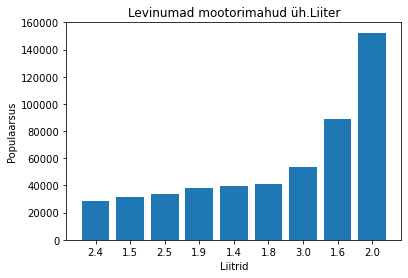

In [29]:
plt.bar(*zip(*res.items()))
plt.title('Levinumad mootorimahud üh.Liiter')
plt.ylabel('Populaarsus')
plt.xlabel('Liitrid')
plt.show()

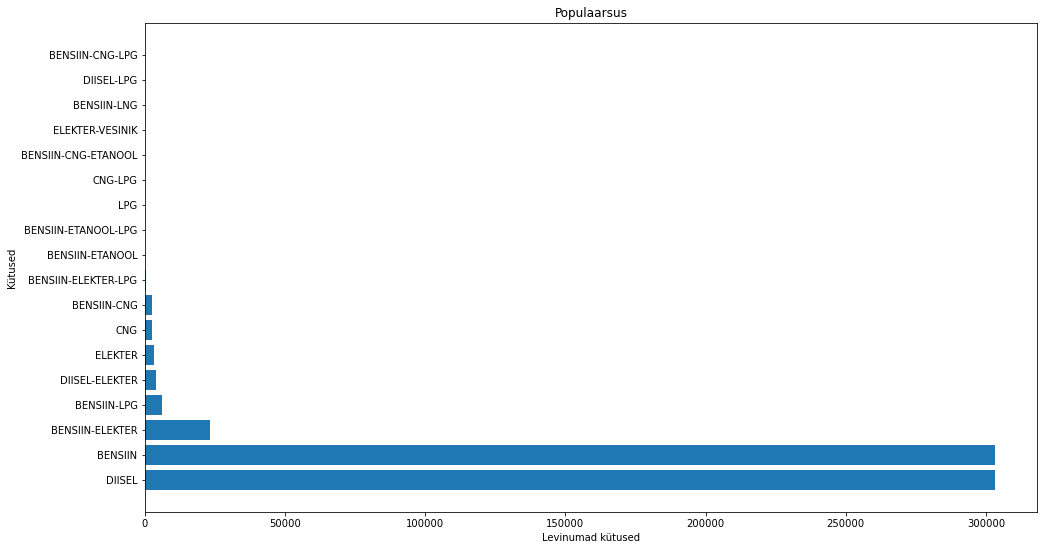

In [30]:
kütused = {}
data["Kütusekombinatsioon"] = data["Kütusekombinatsioon"].fillna("TEADMATA")
for i in range(len(data["Kütusekombinatsioon"])):
    kütus = data["Kütusekombinatsioon"].iloc[i]
    if str(kütus) not in kütused:
        kütused[str(kütus)] = 1
    else:
        kütused[str(kütus)]=kütused.get(str(kütus))+1
kütused=dict(sorted(kütused.items(), key=lambda item: item[1]))
kütused = dict(reversed(list(kütused.items())))

fig, ax = plt.subplots(figsize =(16, 9))

ax.barh(*zip(*kütused.items()))

ax.set_xlabel('Levinumad kütused')
ax.set_ylabel('Kütused')
ax.set_title('Populaarsus')

#plt.xlim([115,140])

plt.show()

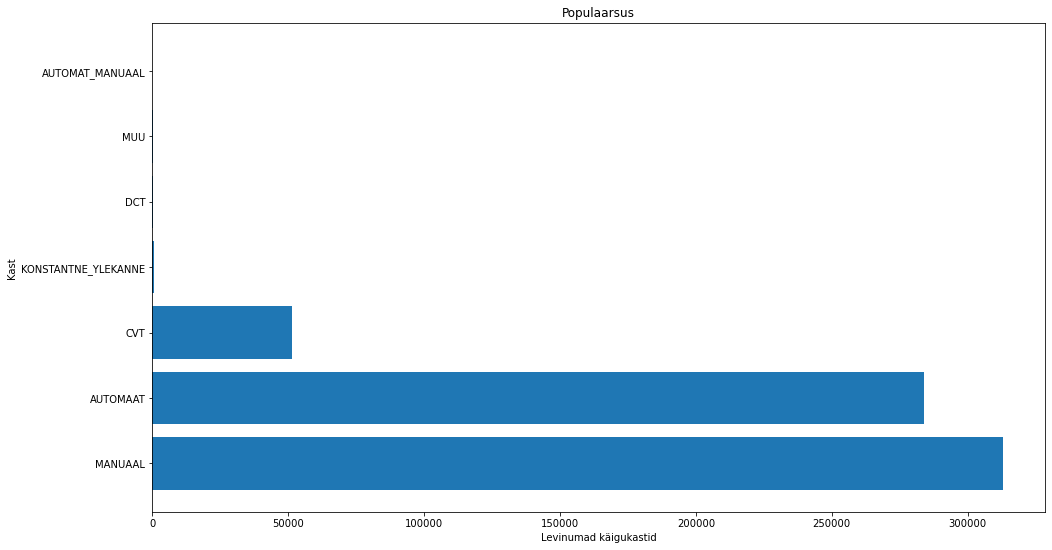

In [31]:
käigukastid = {}
data["KAIGUKASTI_TYYP"] = data["KAIGUKASTI_TYYP"].fillna("TEADMATA")
for i in range(len(data["KAIGUKASTI_TYYP"])):
    käigukast = data["KAIGUKASTI_TYYP"].iloc[i]
    if str(käigukast) not in käigukastid:
        käigukastid[str(käigukast)] = 1
    else:
        käigukastid[str(käigukast)]=käigukastid.get(str(käigukast))+1
käigukastid=dict(sorted(käigukastid.items(), key=lambda item: item[1]))
käigukastid = dict(reversed(list(käigukastid.items())))

fig, ax = plt.subplots(figsize =(16, 9))

ax.barh(*zip(*käigukastid.items()))

ax.set_xlabel('Levinumad käigukastid')
ax.set_ylabel('Kast')
ax.set_title('Populaarsus')

plt.show()

In [32]:
aastad = {}
for i in range(len(data["ESMANE_REG_KP"])):
    aasta = int(str(data["ESMANE_REG_KP"].iloc[i])[6:10])
    if aasta not in aastad:
        aastad[aasta] = 1
    else:
        aastad[aasta]=aastad.get(aasta)+1

In [33]:
aastad=dict(sorted(aastad.items(), key=lambda item: item[1]))

aasta_vahemikud = ["1900-1989", "1990-1999", "2000-2005", "2006-2010", "2010-2015", "2016-2020", "2021+"]
autode_arv_vahemikus = [0,0,0,0,0,0,0]

for key, value in aastad.items():
    if key > 1899 and key < 1990:
        autode_arv_vahemikus[0] = autode_arv_vahemikus[0] + value
    elif key > 1899 and key < 2000:
        autode_arv_vahemikus[1] = autode_arv_vahemikus[1] + value
    elif key > 1999 and key < 2006:
        autode_arv_vahemikus[2] = autode_arv_vahemikus[2] + value
    elif key > 2005 and key < 2011:
        autode_arv_vahemikus[3] = autode_arv_vahemikus[3] + value
    elif key > 2010 and key < 2016:
        autode_arv_vahemikus[4] = autode_arv_vahemikus[4] + value
    elif key > 2015 and key < 2021:
        autode_arv_vahemikus[5] = autode_arv_vahemikus[5] + value
    else:
        autode_arv_vahemikus[6] = autode_arv_vahemikus[6] + value

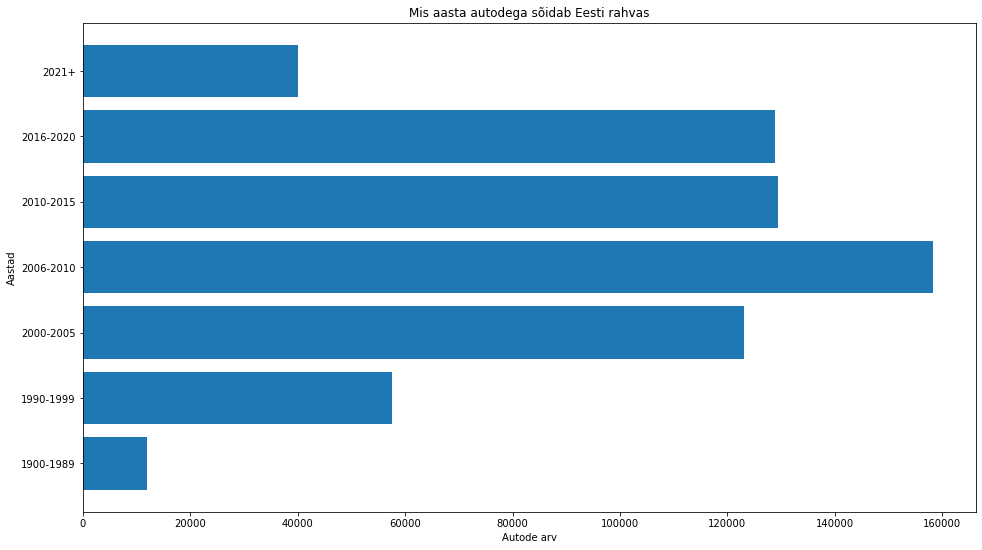

In [34]:
fig, ax = plt.subplots(figsize =(16, 9))

ax.barh(aasta_vahemikud, autode_arv_vahemikus)

ax.set_xlabel('Autode arv')
ax.set_ylabel('Aastad')
ax.set_title('Mis aasta autodega sõidab Eesti rahvas')

plt.show()

In [35]:
võimsuse_vahemikud = ["0-50", "51-100", "101-150", "151-200", "201-250", "251+"]
autode_arv_võimsuse_vahemikus = [0,0,0,0,0,0]

for i in range(len(data["MOOTORI_VOIMSUS"])):
    võimsus_str = str(data["MOOTORI_VOIMSUS"].iloc[i])
    if ',' in võimsus_str:
        võimsus_str=võimsus_str.replace(",",".")
    võimsus = float(võimsus_str)
    if võimsus <= 50:
        autode_arv_võimsuse_vahemikus[0] = autode_arv_võimsuse_vahemikus[0] + 1
    elif võimsus <= 100 and võimsus > 50:
        autode_arv_võimsuse_vahemikus[1] = autode_arv_võimsuse_vahemikus[1] + 1
    elif võimsus <= 150 and võimsus > 100:
        autode_arv_võimsuse_vahemikus[2] = autode_arv_võimsuse_vahemikus[2] + 1
    elif võimsus <= 200 and võimsus > 150:
        autode_arv_võimsuse_vahemikus[3] = autode_arv_võimsuse_vahemikus[3] + 1
    elif võimsus <= 250 and võimsus > 200:
        autode_arv_võimsuse_vahemikus[4] = autode_arv_võimsuse_vahemikus[4] + 1
    else:
        autode_arv_võimsuse_vahemikus[5] = autode_arv_võimsuse_vahemikus[5] + 1

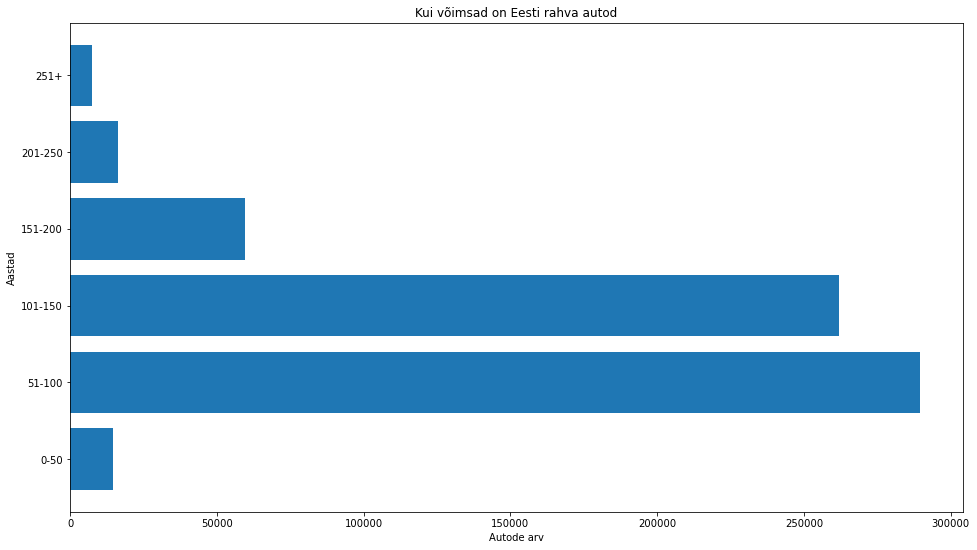

In [36]:
fig, ax = plt.subplots(figsize =(16, 9))

ax.barh(võimsuse_vahemikud, autode_arv_võimsuse_vahemikus)

ax.set_xlabel('Autode arv')
ax.set_ylabel('Aastad')
ax.set_title('Kui võimsad on Eesti rahva autod')

plt.show()

In [37]:
#BIG PREDICTION
#tootmisaasta -> keskmise CO2 ->predictime järgnevad aastad CO2 (mis kütus)

In [38]:
data.head()

,ESMANE_REG_KP,KAIGUKASTI_TYYP,MOOTORI_MAHT,MOOTORI_VOIMSUS,Kütusekombinatsioon,CO2_NEDC,Mark,Mudel,REG_MASS,HEITMENORM,VK/OM MAAKOND
0,18.05.2020,AUTOMAAT,1332.0,117,BENSIIN,131.0,NISSAN,QASHQAI,1885,EURO6,HARJU MAAKOND
1,01.01.1938,MANUAAL,2127.0,79,BENSIIN,NaN,VAUXHALL,-,1450,NaN,PÄRNU MAAKOND
2,01.01.1960,MANUAAL,2445.0,55,BENSIIN,NaN,GAZ,21I,1875,NaN,TARTU MAAKOND
3,01.01.1969,MANUAAL,1360.0,36,BENSIIN,NaN,AZLK,408,1290,NaN,VALGA MAAKOND
4,01.01.1974,MANUAAL,1450.0,55,BENSIIN,210.0,VAZ,2103,1430,NaN,VÕRU MAAKOND


In [59]:
big_predict=data.copy()

In [60]:
big_predict["AASTA"]=data["ESMANE_REG_KP"].str[-4:]
big_predict=big_predict.drop(["ESMANE_REG_KP","Mark","Mudel","VK/OM MAAKOND"], axis=1)
big_predict=big_predict.dropna()

In [61]:
big_predict=big_predict.reset_index()
big_predict=big_predict.drop(["index"], axis=1)

In [62]:

vägaoluline=["BENSIIN-CNG-LPG","DIISEL-LPG","BENSIIN-LNG","ELEKTER-VESINIK","BENSIIN-CNG-ETANOOL","CNG-LPG","LPG","BENSIIN-ETANOOL-LPG","BENSIIN-ETANOOL","BENSIIN-ELEKTER-LPG", "BENSIIN-CNG","DIISEL-ELEKTER", "BENSIIN-LPG", "BENSIIN-ELEKTER"] 
for i in range(len(vägaoluline)):
    big_predict["Kütusekombinatsioon"]=big_predict["Kütusekombinatsioon"].replace([vägaoluline[i]],"MUU")
    
for i in range(len(big_predict["HEITMENORM"])):
    if "EURO 6" in str(big_predict["HEITMENORM"].iloc[i]):
        big_predict.loc[i, "HEITMENORM"]="EURO6"

big_predict.tail(25)

,KAIGUKASTI_TYYP,MOOTORI_MAHT,MOOTORI_VOIMSUS,Kütusekombinatsioon,CO2_NEDC,REG_MASS,HEITMENORM,AASTA
466561,KONSTANTNE_YLEKANNE,0.0,158,ELEKTER,0.0,3170,AX,2022
466562,AUTOMAAT,2993.0,145,DIISEL,172.0,2140,EURO4,2007
466563,AUTOMAAT,1997.0,125,DIISEL,193.0,3070,EURO6,2022
466564,MANUAAL,1199.0,81,BENSIIN,145.0,2050,EURO6,2022
466565,MANUAAL,1499.0,75,DIISEL,136.0,2120,EURO6,2022
466566,MANUAAL,1598.0,"110,1",BENSIIN,153.0,2085,EURO6,2022
466567,AUTOMAAT,1499.0,96,DIISEL,121.0,1795,EURO6,2022
466568,MANUAAL,1598.0,77,DIISEL,109.0,1960,EURO5,2012
466569,MANUAAL,1560.0,80,DIISEL,132.0,1900,EURO4,2006
466570,AUTOMAAT,2400.0,120,DIISEL,199.0,2400,EURO4,2009


In [ ]:
columns = big_predict.columns
big_predict = pd.get_dummies(big_predict, columns=['KAIGUKASTI_TYYP', "Kütusekombinatsioon"])
#big_predict=big_predict.drop(['KAIGUKASTI_TYYP', "Kütusekombinatsioon"], axis=1)
big_predict.head(25)

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.loc[:, data.columns!="CO2_NEDC"],data["CO2_NEDC"], test_size=0.3, random_state=1)

In [ ]:
from sklearn.linear_model import LinearRegression
genius_regression_model = LinearRegression()

In [ ]:
x=np.array(big_predict[['AASTA','KUU']].astype(int))
y=np.array(big_predict["CO2"])
genius_regression_model.fit(x,y)
print(genius_regression_model.predict([[2026,8]]))

In [ ]:
big_predict.head(25)